<a href="https://colab.research.google.com/github/jnels13/Screening-Childrens-Writing-Level-With-NLP/blob/main/Predicting_Children's_Writing_by_Grade_Level.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicting Children's Grade-Group Writing Level**

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

import string
import io
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 50)
import six
from imblearn.over_sampling import SMOTE 
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, svm
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
import xgboost as xgb
import gensim

import warnings
warnings.filterwarnings("ignore")

rand_state = 123

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


### Import Dataset

In [155]:
# Run this cell to load the corpus
from google.colab import files
uploaded = files.upload()
file_name = list(uploaded.keys())[0] 
print("Confirmed that",file_name,"was uploaded.")

Saving writingcsv2_combined.csv to writingcsv2_combined (1).csv
Confirmed that writingcsv2_combined.csv was uploaded.


In [156]:
data = pd.read_csv(io.BytesIO(uploaded[file_name]),
                   skipinitialspace=True,
                   sep=',', 
                   quotechar='"', 
                   escapechar='\\',
                   error_bad_lines=False, 
                   names=['Grade', 'Text'])

# SAVE IN CASE RETURN TO LOCAL ENVIRONMENT FROM COLAB
# data = pd.read_csv("writingcsv2_combined.csv",
#                    skipinitialspace=True,
#                    sep=',', 
#                    quotechar='"', 
#                    escapechar='\\',
#                    error_bad_lines=False, 
#                    names=['Grade', 'Text'])

## Categorize Text Samples and Labels

In [157]:
#Number of Texts
len(data.Grade)

288

In [158]:
#Review counts per grade level
#Some texts were attributed to multiple grade levels, and thus were only assigned the lowest grade
#(for high school, it would be grade 9)

data.Grade.value_counts()

6     47
9     44
2     37
4     36
3     34
1     29
5     18
0     18
8      8
7      8
11     4
12     3
10     2
Name: Grade, dtype: int64

In [100]:
#Categorize text samples into broader grade-groups due to limited corpus size

data.loc[(data['Grade'] >= 0) & (data['Grade'] <= 2), 'Category'] = '0-2'
data.loc[(data['Grade'] >= 3) & (data['Grade'] <= 4), 'Category'] = '3-4'
data.loc[(data['Grade'] >= 5) & (data['Grade'] <= 8), 'Category'] = '5-8'
data.loc[(data['Grade'] >= 9) & (data['Grade'] <= 12), 'Category'] = '9-12'

In [101]:
#Review distribution of texts between different grade-groups
imbalance=data.Category.value_counts()

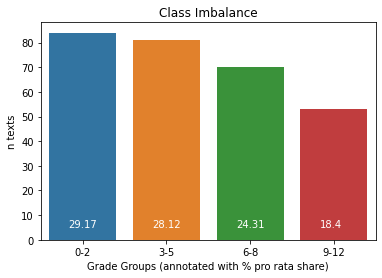

In [102]:
#Visualize potential class imbalance

sns.barplot([0,1,2,3], imbalance)
plt.xticks([0,1,2,3],['0-2', '3-5', '6-8', '9-12'])
plt.xlabel('Grade Groups (annotated with % pro rata share)')
plt.ylabel('n texts')
plt.title('Class Imbalance')
tot=len(data.Category)
for i in range(4):
    plt.annotate(round(imbalance[i]/tot*(100),2),xy=(i-.17,5), color='white')
plt.show()

In [103]:
data = data.drop(['Grade'], axis=1)

## Data Exploration & Preprocessing

In [104]:
data.Text.head()

0    How Much I Know About Space I had just gone to...
1    My Favorite Pet My cat is fluffy. His name is ...
2    Sweet Spring Spring is sweet because we can go...
3    A Happy Day One day baby Josh came home. He wa...
4    My Trip to Mexico One time I went to Mexico. I...
Name: Text, dtype: object

In [105]:
def tokenize_ (text):
    return word_tokenize(text)

In [106]:
def stopped_ (data):
    stopwords_list = stopwords.words('english') #removing stopwords
    stopwords_list += list(string.punctuation)  #removing punctuation
    return([w.lower() for w in data if (w not in stopwords_list)])

In [107]:
def lemma_(data):
    lemmatizer = WordNetLemmatizer()
    data = [lemmatizer.lemmatize(w) for w in data]     
    return(data)

In [108]:
data['Text_tokenized'] = data.Text.apply(tokenize_)

In [109]:
data['Text_lemmatized'] = data.Text_tokenized.apply(stopped_)

In [110]:
data.Text_lemmatized = data.Text_lemmatized.apply(lemma_)

In [111]:
data.head()

,Text,Category,Text_tokenized,Text_lemmatized
0,How Much I Know About Space I had just gone to...,0-2,"[How, Much, I, Know, About, Space, I, had, jus...","[how, much, i, know, about, space, i, gone, ch..."
1,My Favorite Pet My cat is fluffy. His name is ...,0-2,"[My, Favorite, Pet, My, cat, is, fluffy, ., Hi...","[my, favorite, pet, my, cat, fluffy, his, name..."
2,Sweet Spring Spring is sweet because we can go...,0-2,"[Sweet, Spring, Spring, is, sweet, because, we...","[sweet, spring, spring, sweet, go, boat, ridin..."
3,A Happy Day One day baby Josh came home. He wa...,0-2,"[A, Happy, Day, One, day, baby, Josh, came, ho...","[a, happy, day, one, day, baby, josh, came, ho..."
4,My Trip to Mexico One time I went to Mexico. I...,0-2,"[My, Trip, to, Mexico, One, time, I, went, to,...","[my, trip, mexico, one, time, i, went, mexico,..."


The new column "Text_lemmatized" contains the lemmatized, tokenized texts with stop-words removed. 

### **Visualization of Corpus**

In [112]:
#Review dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Text             288 non-null    object
 1   Category         288 non-null    object
 2   Text_tokenized   288 non-null    object
 3   Text_lemmatized  288 non-null    object
dtypes: object(4)
memory usage: 9.1+ KB


In [113]:
# Create a column containing the number of words per each original text 
data['num_words'] = data['Text'].str.len()  

In [114]:
# Create a column containing average word length for each original text 
temp_token_list = list(data['Text_tokenized'])
new_token_list = []
for item in temp_token_list:
    new_token_list.append(np.average([len(w) for w in item]))
data['avg_orig_word_len'] = new_token_list

In [115]:
# Create a column containing average word length for each lemmatized text 
temp_lemma_list = list(data['Text_lemmatized'])
new_lemma_list = []
for item in temp_lemma_list:
    new_lemma_list.append(np.average([len(w) for w in item]))
data['avg_lem_word_len'] = new_lemma_list

In [116]:
# Review new columns
data.head(5)

,Text,Category,Text_tokenized,Text_lemmatized,num_words,avg_orig_word_len,avg_lem_word_len
0,How Much I Know About Space I had just gone to...,0-2,"[How, Much, I, Know, About, Space, I, had, jus...","[how, much, i, know, about, space, i, gone, ch...",365,3.641975,4.283019
1,My Favorite Pet My cat is fluffy. His name is ...,0-2,"[My, Favorite, Pet, My, cat, is, fluffy, ., Hi...","[my, favorite, pet, my, cat, fluffy, his, name...",210,3.000000,3.827586
2,Sweet Spring Spring is sweet because we can go...,0-2,"[Sweet, Spring, Spring, is, sweet, because, we...","[sweet, spring, spring, sweet, go, boat, ridin...",255,3.383333,4.185185
3,A Happy Day One day baby Josh came home. He wa...,0-2,"[A, Happy, Day, One, day, baby, Josh, came, ho...","[a, happy, day, one, day, baby, josh, came, ho...",131,3.058824,3.681818
4,My Trip to Mexico One time I went to Mexico. I...,0-2,"[My, Trip, to, Mexico, One, time, I, went, to,...","[my, trip, mexico, one, time, i, went, mexico,...",243,3.096774,3.947368


In [117]:
#Review descriptive statistics about the corpus before and after preprocessing
print(data.groupby('Category').describe().reset_index().sort_values('Category', ascending=True))

  Category num_words                                                                     \
               count         mean          std    min      25%     50%     75%      max   
0      0-2      84.0   413.523810   285.131484   26.0   185.75   370.0   605.0   1648.0   
1      3-4      70.0  1185.628571   561.531786  121.0   739.25  1227.5  1540.0   2731.0   
2      5-8      81.0  2743.111111  1604.239212  456.0  1859.00  2418.0  3060.0   9705.0   
3     9-12      53.0  4332.943396  2350.536702  755.0  2851.00  3576.0  5434.0  11395.0   

  avg_orig_word_len                                                                        \
              count      mean       std       min       25%       50%       75%       max   
0              84.0  3.504695  0.396215  2.333333  3.244792  3.494681  3.751025  4.625000   
1              70.0  3.527131  0.289879  2.881818  3.361371  3.522176  3.695111  4.606154   
2              81.0  3.781991  0.336416  3.129754  3.533505  3.714286  3.989796  

When looking at the number of words per text, they follow a relatively predicatble pattern, with the min/max, mean, and standard deviation increasing rather significantly with grade-group.  The average length of words (original and pre-processed) per grade-group level does not appear to correlate nearly as much, though; average word lengths are much closer and do trend up with grade-group, but are within 1-2 standard deviations of their neighbors. The visualizations below highlight these differences:

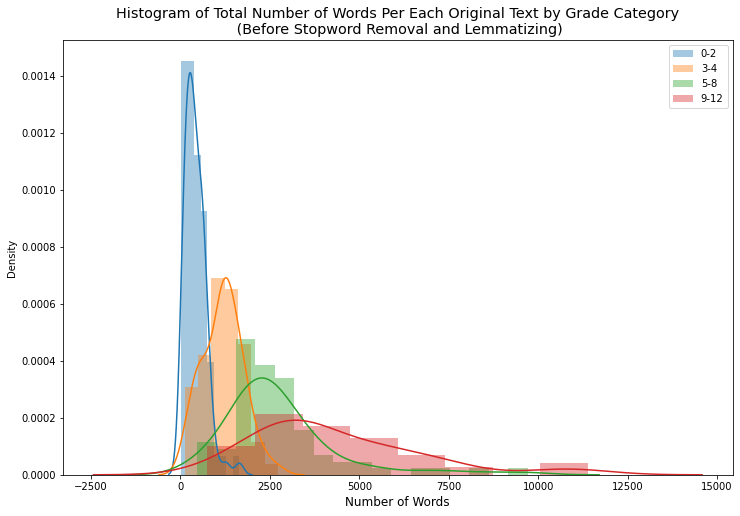

In [118]:
#Distribution of Number of Words per Text
plt.figure(figsize=(12,8))
plt.title('Histogram of Total Number of Words Per Each Original Text by Grade Category\n (Before Stopword Removal and Lemmatizing)', size='x-large')
for name, group in data.groupby('Category'):
    sns.distplot(group['num_words'], label=name)
plt.legend()
plt.xlabel('Number of Words', size='large')
plt.show()

The text lengths for K-2 grade are much shorter than the higher grades. Lengths of middle and high school texts are much more comparable.

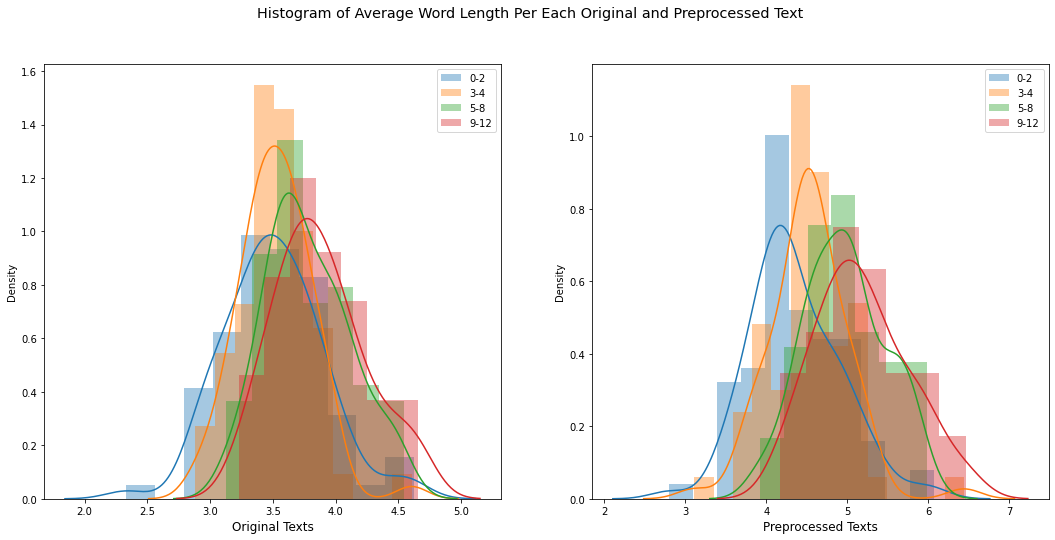

In [119]:
#Visualize distribution of word lengths between original and preprocessed texts


fig, ax = plt.subplots(1,2, figsize=(18, 8))
ax0 = ax[0]
ax1 = ax[1]
for name, group in data.groupby('Category'):
    sns.distplot(group['avg_orig_word_len'], label=name, ax=ax0)
for name, group in data.groupby('Category'):
    sns.distplot(group['avg_lem_word_len'], label=name, ax=ax1)
ax0.set_xlabel('Original Texts', size='large')
ax0.legend()
ax1.set_xlabel('Preprocessed Texts', size='large')
ax1.legend()
fig.suptitle('Histogram of Average Word Length Per Each Original and Preprocessed Text', size='x-large')
plt.show()

    

Overall, there is a LOT of overlap in the distributions between all of the grade-groups, with the most striking being between the upper two.  The distributions of word lengths are much higher in the stopped/lemmatized group (peaking between 4-5 for stopped/lemmatized texts, compared to about 3.5 for the original texts.  The distributions of the original texts are also much closer together, likely due to the inclusion of the stop words. 

## Visualize the Text Itself: Wordclouds by Grade-Group

In [120]:
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

In [121]:
# Generate word cloud
def make_wordcloud(category_):
  wordcloud = WordCloud(width = 800, height = 600, 
                        random_state=rand_state, 
                        background_color='white', 
                        colormap='Dark2', 
                        collocations=False, 
                        stopwords = STOPWORDS).generate(' '.join(data['Text'].loc[data['Category']== category_]))
  # plot_cloud(wordcloud)
  plt.figure( figsize=(8,6), facecolor='w')
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.title(category_)
  plt.tight_layout(pad=0)
  plt.show()

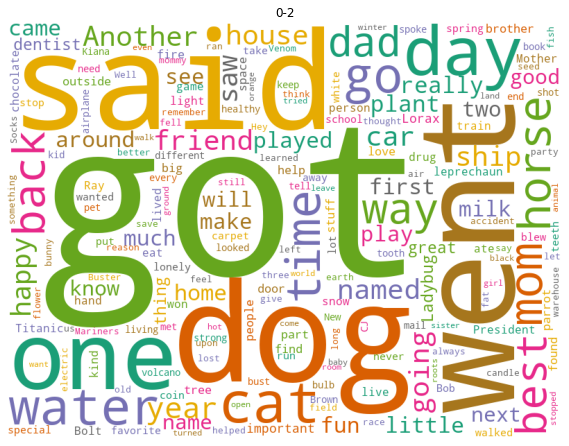

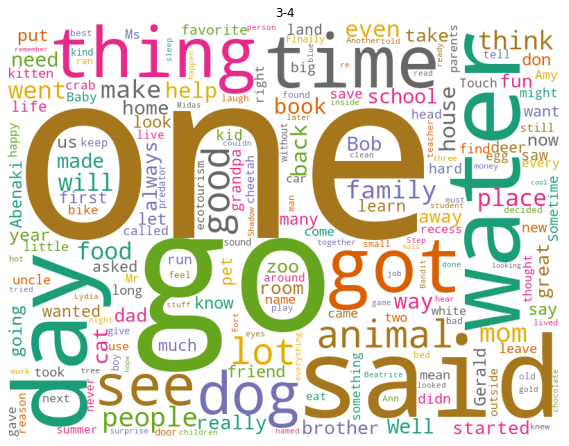

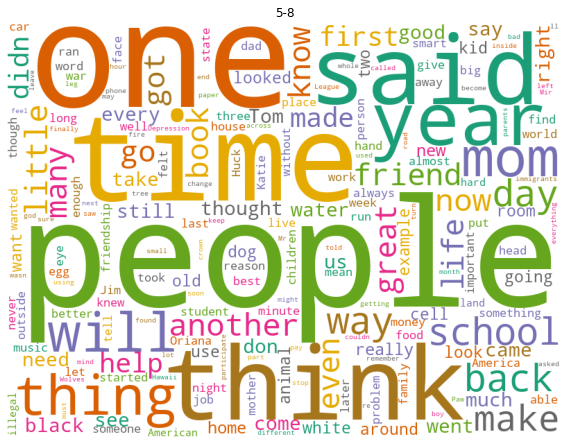

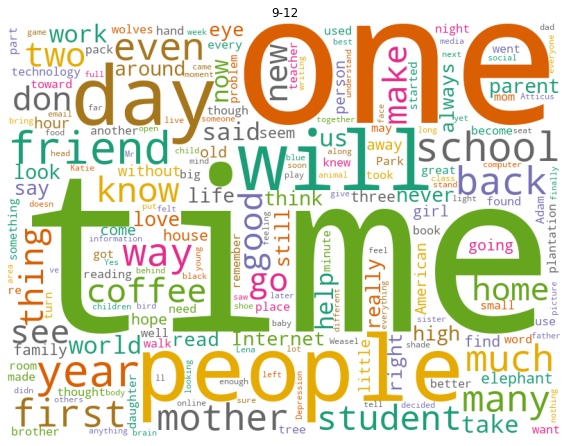

(None, None)

In [122]:
make_wordcloud('0-2'), make_wordcloud('3-4')
make_wordcloud('5-8'), make_wordcloud('9-12')


Dogs and cats are important in younger grade levels, but drop off as age increases. "Mom" is always prominent, but becomes "mother" in high school. "People" grows in frequency in middle and high school. "Time" appears to grow in frequency as grade levels increase.  

# **Weight and Vectorize the Texts**

In [123]:
X_train, X_test, y_train, y_test = train_test_split(
    data['Text_lemmatized'],data['Category'],test_size=0.3, random_state=rand_state, stratify=data['Category'])

In [124]:
# Y labels to use with all models
Encoder = LabelEncoder()
y_train = Encoder.fit_transform(y_train)
y_test = Encoder.fit_transform(y_test)

### **TF-IDF Weighting**

In [125]:
lemmas = data['Text_lemmatized'].apply(lambda x: ' '.join(x))
lemma_Train_X = X_train.apply(lambda x: ' '.join(x))
lemma_Test_X  = X_test.apply(lambda x: ' '.join(x))

Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(lemmas)
X_train_tfidf = Tfidf_vect.transform(lemma_Train_X)
X_test_tfidf = Tfidf_vect.transform(lemma_Test_X)

In [126]:
#Use SMOTE to account for class imbalances
sm = SMOTE(sampling_strategy='auto', k_neighbors=2, random_state=rand_state)
X_train_tfidf,y_train_tfidf = sm.fit_resample(X_train_tfidf, y_train) 

In [127]:
pd.DataFrame(X_train_tfidf).shape

(236, 1)

### **Word2vec Vectorization**

In [128]:
num_features=300
model = gensim.models.Word2Vec(data.Text_lemmatized, 
                               size=num_features, 
                               min_count=2, 
                               workers=4, 
                               seed=1, 
                               iter=50, window=5)

In [129]:
model.wv.syn0.shape

(4769, 300)

In [130]:
#Just for fun, to see if it's working
model.wv.doesnt_match("red green bus".split())

'bus'

In [131]:
# Function to average all word vectors in a paragraph (from https://www.kaggle.com/varun08/sentiment-analysis-using-word2vec)
def featureVecMethod(words, model, num_features):
    # Pre-initialising empty numpy array for speed
    featureVec = np.zeros(num_features,dtype="float32")
    nwords = 0
    
    #Converting Index2Word which is a list to a set for better speed in the execution.
    index2word_set = set(model.wv.index2word)
    
    for word in  words:
        if word in index2word_set:
            nwords = nwords + 1
            featureVec = np.add(featureVec,model[word])
    
    # Dividing the result by number of words to get average
    featureVec = np.divide(featureVec, nwords)
    return featureVec

In [132]:
# Function for calculating the average feature vector (from https://www.kaggle.com/varun08/sentiment-analysis-using-word2vec)
def getAvgFeatureVecs(reviews, model, num_features):
    counter = 0
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    for review in reviews:
        # Printing a status message every 1000th review
        if counter%1000 == 0:
            print("Review %d of %d"%(counter,len(reviews)))
            
        reviewFeatureVecs[counter] = featureVecMethod(review, model, num_features)
        counter = counter+1
        
    return reviewFeatureVecs

In [133]:
trainDataVecs = getAvgFeatureVecs(X_train, model, num_features)
testDataVecs =  getAvgFeatureVecs(X_test, model, num_features)

Review 0 of 201
Review 0 of 87


In [134]:
trainDataVecs.shape, testDataVecs.shape

((201, 300), (87, 300))

In [135]:
X_train_w2v,y_train_w2v = sm.fit_sample(trainDataVecs, y_train) 

# **Models**

In [136]:
def dummy_classifier(X_train, X_test, y_train, y_test):
  dummy_clf = DummyClassifier(strategy="stratified", random_state=rand_state)
  dummy_clf.fit(X_train, y_train)
  dummy_accuracy = (round(dummy_clf.score(X_test, y_test)*100,3))
  return(dummy_accuracy)

In [137]:
def svm_classifier(X_train, X_test, y_train, y_test):
  """
  Takes in train-test-split for X,y;
  Runs RandomizedSearchCV and then uses the 
  best parameters to run an SVM model
  and returns an Accuracy Score and
  F1 Score.
  """
  clf_svm = svm.SVC(random_state=rand_state)

  param_grid = {'C': [0.1, 1, 10, 100, 1000],  
                'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
                'kernel': ['rbf', 'linear', 'sigmoid', 'poly'],
                'degree': [1,2,3,4]} 

  gs_svm = RandomizedSearchCV(SVC(), param_grid, cv=5)
  gs_svm.fit(X_train,y_train)
  best = gs_svm.best_params_
  
  SVM = svm.SVC(C=best['C'], 
                kernel=best['kernel'], 
                degree=best['degree'], 
                gamma=best['gamma'], 
                random_state=rand_state)
  SVM.fit(X_train,y_train)
  y_hat = SVM.predict(X_test)
  print('SVM best params:',best)
  return (round(accuracy_score(y_test, y_hat)*100,3), round(f1_score(y_test, y_hat, average='macro')*100,3))

In [138]:
def rf_classifier(X_train, X_test, y_train, y_test):
  """
  Takes in train-test-split for X,y;
  Runs RandomizedSearchCV for the best parameters,
  and then runs a random forest and returns an 
  Accuracy Score and F1 Score.
  """
  clf_rf = RandomForestClassifier(random_state=rand_state)

  param_grid = {'criterion': ['gini', 'entropy'],  
                'n_estimators':[50,75,100,150],
                'max_depth': [25,100,150], 
                'min_samples_split': [1,5,20,200]} 

  gs_rf = RandomizedSearchCV(clf_rf, param_grid, cv=5)
  gs_rf.fit(X_train,y_train)
  best = gs_rf.best_params_
  
  forest = RandomForestClassifier(criterion=best['criterion'],
                                  n_estimators=best['n_estimators'],
                                  max_depth=best['max_depth'],
                                  min_samples_split=best['min_samples_split'],
                                  random_state=rand_state)
  forest_tf = forest.fit(X_train,y_train)
  y_hat = forest.predict(X_test)
  print('Random forest best params:',best)
  return (round(accuracy_score(y_test, y_hat)*100,3), round(f1_score(y_test, y_hat, average='macro')*100,3))

In [139]:
def xgb_classifier(X_train, X_test, y_train, y_test):
  """
  Takes in train-test-split for X,y;
  Runs RandomizedSearchCV and then uses the 
  best parameters to run an Extreme Gradient Boost model
  and returns an Accuracy Score and F1 Score.
  """
  clf_xgb = xgb.XGBClassifier(random_state=rand_state)

  param_grid = {'learning_rate': [0.3],  
                'n_estimators': [100,150], 
                'max_depth': [3,6,8],
                'gamma': [0.1,0.4]} 

  gs_xgb = RandomizedSearchCV(clf_xgb, param_grid, cv=5)
  gs_xgb.fit(X_train, y_train)
  best = gs_xgb.best_params_

  XGB = xgb.XGBClassifier(learning_rate=best['learning_rate'], 
                          n_estimators=best['n_estimators'], 
                          max_depth=best['max_depth'],
                          gamma=best['gamma'],
                          random_state=rand_state)
  XGB.fit(X_train, y_train)
  y_hat = XGB.predict(X_test)
  print('XGB best params:',best)
  return (round(accuracy_score(y_test, y_hat)*100,3), round(f1_score(y_test, y_hat, average='macro')*100,3))

In [140]:
def combined_models(X_train, X_test, y_train, y_test):
  """
  Runs all four models used in this notebook, including the 
  dummy classifier, SVM, Random Forest, and XGBoost models.
  Takes full train-test-split for X,y.
  """
  dum = dummy_classifier(X_train, X_test, y_train, y_test)
  svm = svm_classifier(X_train, X_test, y_train, y_test)
  rfc = rf_classifier(X_train, X_test, y_train, y_test)
  xgb = xgb_classifier(X_train, X_test, y_train, y_test)
  print('\nDummy Classifier Accuracy:', dum)
  print('SVM Classifier Accuracy, F1 Score (macro):', svm)
  print('Random Forest Accuracy, F1 Score (macro):', rfc)
  print('XG Boost Accuracy, F1 Score (macro):', xgb)
  return()


## **Application of Models to Datasets**

### Iteration 1: Initial, Multi-Source Dataset (n=188) <br>(don't run these cells after initial dataset is loaded)

In [47]:
#Test the TF-IDF weighted texts
combined_models(X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test)

SVM best params: {'kernel': 'poly', 'gamma': 1, 'degree': 2, 'C': 100}
Random forest best params: {'n_estimators': 150, 'min_samples_split': 5, 'max_depth': 100, 'criterion': 'entropy'}
XGB best params: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.3, 'gamma': 0.1}

Dummy Classifier Accuracy: 19.298
SVM Classifier Accuracy, F1 Score (macro): (38.596, 37.069)
Random Forest Accuracy, F1 Score (macro): (50.877, 47.639)
XG Boost Accuracy, F1 Score (macro): (45.614, 45.348)


()

In [48]:
#Test the Word2vec vectorized texts
combined_models(X_train_w2v, testDataVecs, y_train_w2v, y_test)

SVM best params: {'kernel': 'rbf', 'gamma': 1, 'degree': 3, 'C': 100}
Random forest best params: {'n_estimators': 150, 'min_samples_split': 5, 'max_depth': 150, 'criterion': 'gini'}
XGB best params: {'n_estimators': 150, 'max_depth': 6, 'learning_rate': 0.3, 'gamma': 0.1}

Dummy Classifier Accuracy: 19.298
SVM Classifier Accuracy, F1 Score (macro): (43.86, 44.12)
Random Forest Accuracy, F1 Score (macro): (40.351, 40.995)
XG Boost Accuracy, F1 Score (macro): (33.333, 33.66)


()

### Iteration 2: Single-Source, Common-Core Dataset (n=100)

In [94]:
#Test the TF-IDF weighted texts
combined_models(X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test)

SVM best params: {'kernel': 'linear', 'gamma': 0.01, 'degree': 4, 'C': 10}
Random forest best params: {'n_estimators': 150, 'min_samples_split': 5, 'max_depth': 100, 'criterion': 'gini'}
XGB best params: {'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.3, 'gamma': 0.4}

Dummy Classifier Accuracy: 16.129
SVM Classifier Accuracy, F1 Score (macro): (54.839, 33.463)
Random Forest Accuracy, F1 Score (macro): (61.29, 35.417)
XG Boost Accuracy, F1 Score (macro): (58.065, 43.729)


()

In [95]:
#Test the Word2vec vectorized texts
combined_models(X_train_w2v, testDataVecs, y_train_w2v, y_test)

SVM best params: {'kernel': 'linear', 'gamma': 0.0001, 'degree': 4, 'C': 1000}
Random forest best params: {'n_estimators': 100, 'min_samples_split': 5, 'max_depth': 150, 'criterion': 'gini'}
XGB best params: {'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.3, 'gamma': 0.1}

Dummy Classifier Accuracy: 16.129
SVM Classifier Accuracy, F1 Score (macro): (41.935, 40.226)
Random Forest Accuracy, F1 Score (macro): (51.613, 52.17)
XG Boost Accuracy, F1 Score (macro): (35.484, 34.47)


()

### Iteration 3: Combined Dataset

In [143]:
#Test the TF-IDF weighted texts
%%time
combined_models(X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test)

SVM best params: {'kernel': 'linear', 'gamma': 0.001, 'degree': 1, 'C': 1}
Random forest best params: {'n_estimators': 75, 'min_samples_split': 5, 'max_depth': 100, 'criterion': 'gini'}
XGB best params: {'n_estimators': 100, 'max_depth': 8, 'learning_rate': 0.3, 'gamma': 0.1}

Dummy Classifier Accuracy: 32.184
SVM Classifier Accuracy, F1 Score (macro): (49.425, 40.614)
Random Forest Accuracy, F1 Score (macro): (63.218, 58.674)
XG Boost Accuracy, F1 Score (macro): (62.069, 60.433)
CPU times: user 4min 14s, sys: 347 ms, total: 4min 14s
Wall time: 4min 14s


()

In [144]:
#Test the Word2vec vectorized texts
%%time
combined_models(X_train_w2v, testDataVecs, y_train_w2v, y_test)

SVM best params: {'kernel': 'linear', 'gamma': 0.001, 'degree': 2, 'C': 1000}
Random forest best params: {'n_estimators': 150, 'min_samples_split': 5, 'max_depth': 25, 'criterion': 'gini'}
XGB best params: {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.3, 'gamma': 0.1}

Dummy Classifier Accuracy: 32.184
SVM Classifier Accuracy, F1 Score (macro): (47.126, 47.113)
Random Forest Accuracy, F1 Score (macro): (47.126, 46.071)
XG Boost Accuracy, F1 Score (macro): (50.575, 50.282)
CPU times: user 1min 46s, sys: 305 ms, total: 1min 46s
Wall time: 1min 46s


()

The best performing model was the Random Forest on TF-IDF weighted texts, at 63.218% accuracy, and the XGBoost with 50.575% accuracy.  We will use these in production. 

# **Final Model** 

### Set up best-functioning models for TF-IDF and Word2vec

In [146]:
# Final model for TF-IDF-weighted texts
clf_rf_tfidf = RandomForestClassifier(n_estimators=75, 
                                      min_samples_split=5, 
                                      max_depth=100, 
                                      criterion='gini',
                                      random_state=rand_state)
clf_rf_tfidf.fit(X_train_tfidf, y_train_tfidf)
y_hat = clf_rf_tfidf.predict(X_test_tfidf)
print(round(accuracy_score(y_test, y_hat)*100,3), round(f1_score(y_test, y_hat, average='macro')*100,3))

63.218 58.674


In [147]:
# Final model for the Word2vec-vectorized texts
clf_xgb_w2v = xgb.XGBClassifier(learning_rate=0.3, 
                          n_estimators=100, 
                          max_depth=6,
                          gamma=0.1,
                          random_state=rand_state)
clf_xgb_w2v.fit(X_train_w2v, y_train_w2v)
y_hat2 = clf_xgb_w2v.predict(testDataVecs)
print(round(accuracy_score(y_test, y_hat2)*100,3), round(f1_score(y_test, y_hat2, average='macro')*100,3))

50.575 50.282


In [148]:
def preprocess_tfidf(text):
  text1 = tokenize_(text)
  text2 = stopped_(text1)
  text3 = lemma_(text2)
  text4 = [' '.join(text3)]
  text5 = Tfidf_vect.transform(text4)
  return(text5)

In [149]:
def preprocess_w2v(text):
  text1 = tokenize_(text)
  text2 = stopped_(text1)
  text3 = lemma_(text2)
  text4 = [' '.join(text3)]
  text5 = getAvgFeatureVecs(text4, model, num_features)
  return(text5)

### **Input text sample to be predicted:**

In [160]:
#RUN THIS CELL AND THEN PASTE UNFORMATTED ESSAY IN THE INPUT BOX
text_sample = (input("Paste the text of the student's work here:"))

Paste the text of the student's work here:SACRAMENTO, Calif. (AP) — California is imposing an overnight curfew for nearly all residents as the most populous state tries to head off a surge of coronavirus cases that threatens to overwhelm its health care system, Gov. Gavin Newsom announced Thursday. What officials are calling a limited stay-at-home order requires people who are not on essential errands to stay home from 10 p.m. to 5 a.m. starting Saturday. The order will last until Dec. 21 but could be extended if disease trends don’t improve. The curfew covers 94% of the state’s nearly 40 million residents. It’s in place in 41 of the state’s 58 counties that have the most significant increases in virus cases and face the most severe restrictions under California’s four-tier system for reopening the economy. ADVERTISEMENT It’s a swift escalation that comes just three days after the state imposed tougher restrictions limiting business operations in those 41 counties. COVID-19 infections,

In [153]:
predict_me_tfidf = preprocess_tfidf(text_sample)
predict_me_w2v = preprocess_w2v(text_sample)

print('Predicted writing level using TF-IDF weights:',Encoder.inverse_transform(clf_rf_tfidf.predict(predict_me_tfidf)))
print('Predicted writing level using Word2vec Vectors:',Encoder.inverse_transform(clf_xgb_w2v.predict(predict_me_w2v)))

Predicted writing level using TF-IDF weights: ['5-8']
Predicted writing level using Word2vec Vectors: ['5-8']


I was taught that newspaper articles should be written to a fifth-grade level.  Both models predict the article I pasted as in the grade 5-8 group. 